# GCN and GAT


In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import pandas as pd
import numpy as np
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)
        self.fc = torch.nn.Linear(num_classes, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return self.fc(x)

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)
        self.fc = torch.nn.Linear(num_classes, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return self.fc(x)

# Load and preprocess data
data = pd.read_csv('C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/7Oct_270Dataset/5VI_CD_CV_16ENV_270_01.csv')
X = data.drop('Seed', axis=1)
y = data['Seed']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a similarity graph using cosine similarity
similarity = cosine_similarity(X_scaled)
edges = np.transpose(np.nonzero(similarity > 0.5))

# Convert to tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y.values, dtype=torch.float).unsqueeze(1)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

# Split indices for training and testing
train_indices, test_indices = train_test_split(np.arange(data.y.size(0)), test_size=0.2, random_state=42)

# Create datasets for given indices
train_dataset = [Data(x=data.x, edge_index=data.edge_index, y=data.y[i]) for i in train_indices]
test_dataset = [Data(x=data.x, edge_index=data.edge_index, y=data.y[i]) for i in test_indices]

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize models
num_node_features = X.shape[1]
num_classes = 1
gcn_model = GCN(num_node_features, num_classes)
gat_model = GAT(num_node_features, num_classes)

# Define optimizer and loss function
criterion = torch.nn.MSELoss()
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=0.01)
optimizer_gat = optim.Adam(gat_model.parameters(), lr=0.01)

# Training loop for GCN
for epoch in range(100):
    gcn_model.train()
    for batch in train_loader:
        optimizer_gcn.zero_grad()
        out = gcn_model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer_gcn.step()

# Training loop for GAT
for epoch in range(100):
    gat_model.train()
    for batch in train_loader:
        optimizer_gat.zero_grad()
        out = gat_model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer_gat.step()

def evaluate_model(model, loader):
    model.eval()
    actual = []
    predicted = []
    with torch.no_grad():
        for batch in loader:
            out = model(batch)
            batch_predictions = out.detach().numpy().flatten()
            batch_actual = batch.y.numpy().flatten()
            # Truncate the predictions to match the length of batch_actual if necessary
            batch_predictions = batch_predictions[:len(batch_actual)]
            predicted.extend(batch_predictions)
            actual.extend(batch_actual)

    # Check if the lengths are consistent
    assert len(predicted) == len(actual), "Predicted and actual arrays have different lengths"

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = sqrt(mse)
    r2 = r2_score(actual, predicted)

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# Evaluate models
gcn_results = evaluate_model(gcn_model, test_loader)
gat_results = evaluate_model(gat_model, test_loader)

# Print results
print("GCN Results:", gcn_results)
print("GAT Results:", gat_results)


c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([8640, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([6480, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


GCN Results: {'MAE': 2.209819, 'MSE': 7.784366, 'RMSE': 2.7900476932892846, 'R2': -0.05799710907069566}
GAT Results: {'MAE': 2.3844757, 'MSE': 9.266993, 'RMSE': 3.0441735444894937, 'R2': -0.25950540975725755}


In [29]:
import pandas as pd

# Define the data for the DataFrame
data = {
    "Method": [
        "PEnsemble1", "PEnsemble2", "PEnsemble3", "PEnsemble4", "GCN", "GAT"
    ],
    "Model": [
        "Huber, M-estimators, Linear Regression, Ridge Regression",
        "Huber, M-estimators, Linear Regression",
        "Huber, M-estimators, Ridge Regression",
        "Huber, M-estimators",
        "Graph Convolutional Network",
        "Graph Attention Network"
    ],
    "MAE": [
        0.308433, 0.308889, 0.311677, 0.291894, 2.209819, 2.384476
    ],
    "MSE": [
        0.531334, 0.531836, 0.532635, 0.522753, 7.784366, 9.266993
    ],
    "RMSE": [
        0.728926, 0.729271, 0.729818, 0.723016, 2.790048, 3.044174
    ],
    "R2": [
        0.924202, 0.924131, 0.924017, 0.925427, -0.057997, -0.259505
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df


,Method,Model,MAE,MSE,RMSE,R2
0,PEnsemble1,"Huber, M-estimators, Linear Regression, Ridge ...",0.308433,0.531334,0.728926,0.924202
1,PEnsemble2,"Huber, M-estimators, Linear Regression",0.308889,0.531836,0.729271,0.924131
2,PEnsemble3,"Huber, M-estimators, Ridge Regression",0.311677,0.532635,0.729818,0.924017
3,PEnsemble4,"Huber, M-estimators",0.291894,0.522753,0.723016,0.925427
4,GCN,Graph Convolutional Network,2.209819,7.784366,2.790048,-0.057997
5,GAT,Graph Attention Network,2.384476,9.266993,3.044174,-0.259505


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for plotting
data = {
    "Method": ["PEnsemble1", "PEnsemble2", "PEnsemble3", "PEnsemble4", "GCN", "GAT"],
    "MAE": [0.308433307, 0.308890253, 0.311676967, 0.291894272, 2.209819, 2.3844757],
    "MSE": [0.531333568, 0.531836063, 0.532634751, 0.522752568, 7.784366, 9.266993],
    "RMSE": [0.728926312, 0.729270912, 0.7298183, 0.723016299, 2.790047693, 3.044173544],
    "R2": [0.924202391, 0.924130707, 0.92401677, 0.925426517, -0.057997109, -0.25950541]
}

df = pd.DataFrame(data)

# Plot for each metric
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# MAE
axs[0, 0].bar(df['Method'], df['MAE'], color='blue')
axs[0, 0].set_title('Mean Absolute Error (MAE)')
axs[0, 0].set_ylabel('MAE')

# MSE
axs[0, 1].bar(df['Method'], df['MSE'], color='red')
axs[0, 1].set_title('Mean Squared Error (MSE)')
axs[0, 1].set_ylabel('MSE')

# RMSE
axs[1, 0].bar(df['Method'], df['RMSE'], color='green')
axs[1, 0].set_title('Root Mean Squared Error (RMSE)')
axs[1, 0].set_ylabel('RMSE')

# R2
axs[1, 1].bar(df['Method'], df['R2'], color='purple')
axs[1, 1].set_title('R-squared (R2)')
axs[1, 1].set_ylabel('R2')

# General layout adjustments
fig.suptitle('Comparison of Model Performance')
plt.tight_layout(pad=3.0)

# Save the figure to file
plot_path = 'C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/5April24/model_performance_comparison.png'
plt.savefig(plot_path)
plt.close()  # Close the plot to prevent it from displaying now

plot_path



'C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/5April24/model_performance_comparison.png'

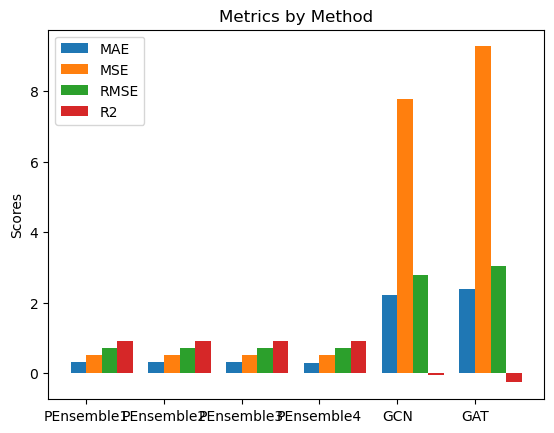

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ['PEnsemble1', 'PEnsemble2', 'PEnsemble3', 'PEnsemble4', 'GCN', 'GAT']
models = ['Huber, M-estimators, Linear Regression, Ridge Regression',
          'Huber, M-estimators, Linear Regression',
          'Huber, M-estimators, Ridge Regression',
          'Huber, M-estimators',
          'Graph Convolutional Network',
          'Graph Attention Network']

mae = [0.308433307, 0.308890253, 0.311676967, 0.291894272, 2.209819, 2.3844757]
mse = [0.531333568, 0.531836063, 0.532634751, 0.522752568, 7.784366, 9.266993]
rmse = [0.728926312, 0.729270912, 0.7298183, 0.723016299, 2.790047693, 3.044173544]
r2 = [0.924202391, 0.924130707, 0.92401677, 0.925426517, -0.057997109, -0.25950541]

x = np.arange(len(methods))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width / 2, mae, width, label='MAE')
rects2 = ax.bar(x + width / 2, mse, width, label='MSE')
rects3 = ax.bar(x + width * 1.5, rmse, width, label='RMSE')
rects4 = ax.bar(x + width * 2.5, r2, width, label='R2')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Metrics by Method')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

plt.show()


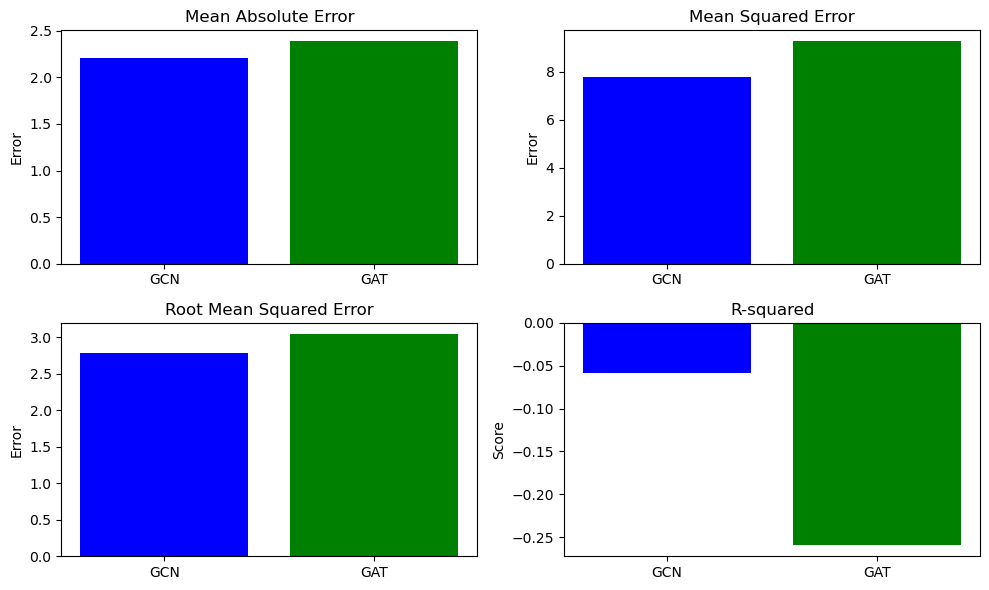

In [28]:
import matplotlib.pyplot as plt

# Data
models = ['GCN', 'GAT']
mae = [2.209819, 2.3844757]
mse = [7.784366, 9.266993]
rmse = [2.7900477, 3.0441735]
r2 = [-0.057997, -0.259505]

# MAE Plot
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.bar(models, mae, color=['blue', 'green'])
plt.title('Mean Absolute Error')
plt.ylabel('Error')

# MSE Plot
plt.subplot(2, 2, 2)
plt.bar(models, mse, color=['blue', 'green'])
plt.title('Mean Squared Error')
plt.ylabel('Error')

# RMSE Plot
plt.subplot(2, 2, 3)
plt.bar(models, rmse, color=['blue', 'green'])
plt.title('Root Mean Squared Error')
plt.ylabel('Error')

# R2 Plot
plt.subplot(2, 2, 4)
plt.bar(models, r2, color=['blue', 'green'])
plt.title('R-squared')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


# Graph Neural Network (GNN) using Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R2),

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch_geometric.nn import GCNConv
from math import sqrt
from torch_geometric.nn import GATConv

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# class GAT(torch.nn.Module):
#     def __init__(self, num_node_features, num_classes):
#         super(GAT, self).__init__()
#         self.conv1 = GATConv(num_node_features, 8, heads=8, dropout=0.6)
#         # On the output layer, we use one head only to obtain a scalar value per node.
#         self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = F.elu(self.conv1(x, edge_index))
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)

# Load and preprocess data
data = pd.read_csv('C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/7Oct_270Dataset/5VI_CD_CV_16ENV_270_01.csv')
X = data.drop('Seed', axis=1)  # Features
y = data['Seed']  # Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a similarity graph using cosine similarity
similarity = cosine_similarity(X_scaled)
edges = np.transpose(np.nonzero(similarity > 0.5))  # Adjust threshold as needed

# Convert to tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y.values, dtype=torch.float).unsqueeze(1)  # Ensure y is the correct shape

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

# Split indices for training and testing
train_indices, test_indices = train_test_split(np.arange(data.y.size(0)), test_size=0.2, random_state=42)

# Create datasets for given indices
train_dataset = [Data(x=data.x, edge_index=data.edge_index, y=data.y[i]) for i in train_indices]
test_dataset = [Data(x=data.x, edge_index=data.edge_index, y=data.y[i]) for i in test_indices]

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the number of features and initialize the model
num_node_features = x.size(1)
model = GCN(num_node_features, 1)

# Initialize the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

# Evaluation loop
model.eval()
predicted = []
actual = []
with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        # Reshape the output to match the actual labels
        batch_predictions = out.detach().numpy().flatten()
        batch_actual = batch.y.numpy().flatten()
        # Truncate the predictions to match the length of batch_actual
        batch_predictions = batch_predictions[:len(batch_actual)]
        predicted.extend(batch_predictions)
        actual.extend(batch_actual)

# Convert lists to NumPy arrays
predicted = np.array(predicted)
actual = np.array(actual)

# Calculate metrics
predicted = np.array(predicted)
actual = np.array(actual)
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = sqrt(mse)
r2 = r2_score(actual, predicted)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([8640, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([6480, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Mean Absolute Error (MAE): 2.176071882247925
Mean Squared Error (MSE): 7.775688648223877
Root Mean Squared Error (RMSE): 2.788492181847365
R-squared (R2): -0.056817772853121395


In [1]:

import pandas as pd

# Load the dataset
file_path = "C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/7Oct_270Dataset/5VI_CD_CV_16ENV_270_01.csv"
data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset
data.head()


,Seed,Cigr_CD,Cire_CD,EVI2_CD,NDRE_CD,NDVI_CD,Cigr_CV,Cire_CV,EVI2_CV,NDRE_CV,...,SoilHumi,EC,Water feed Per Area (m3/dunam),Uv radiation,Evapotranspiration,Daily rain,Rain rate,Humidity,Wind speed,Temperature
0,7.29,1.608679,0.420674,1.000308,0.170101,0.519626,0.955372,0.249832,0.594069,0.101021,...,25.3,57,9.40,8.4,1.98,0,0,55,6,36.0
1,11.05,2.381675,0.663540,1.320603,0.245887,0.651957,3.852529,1.073323,2.136170,0.397739,...,14.0,0,7.51,5.4,1.98,0,0,61,3,35.2
2,6.30,1.456597,0.359851,0.878438,0.150216,0.470997,0.440237,0.108760,0.265496,0.045401,...,26.4,10,1.96,7.0,0.66,0,0,68,3,32.9
3,8.50,1.994122,0.496310,1.138416,0.194519,0.575945,1.439478,0.358267,0.821778,0.140416,...,21.0,389,9.40,8.1,2.67,0,0,54,1,37.0
4,10.10,1.438698,0.368644,0.889822,0.152264,0.472945,0.504922,0.129378,0.312290,0.053438,...,19.8,12,1.96,5.5,0.66,0,0,70,3,31.8


In [15]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Load and preprocess data
data = pd.read_csv('C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/7Oct_270Dataset/5VI_CD_CV_16ENV_270_01.csv')
X = data.drop('Seed', axis=1)  # Features
y = data['Seed']  # Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a similarity graph using cosine similarity
similarity = cosine_similarity(X_scaled)
edges = np.transpose(np.nonzero(similarity > 0.5))  # Adjust threshold as needed

# Convert to tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y.values, dtype=torch.float).unsqueeze(1)  # Ensure y is the correct shape

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

# Split indices for training and testing
train_indices, test_indices = train_test_split(np.arange(data.y.size(0)), test_size=0.2, random_state=42)

# Create datasets for given indices
train_dataset = [Data(x=data.x, edge_index=data.edge_index, y=data.y[i]) for i in train_indices]
test_dataset = [Data(x=data.x, edge_index=data.edge_index, y=data.y[i]) for i in test_indices]

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the number of features
num_node_features = x.size(1)

# Choose the model to train
model = GCN(num_node_features, 1)  # Assuming regression, set the number of output features to 1

# Initialize the loss function and optimizer
criterion = torch.nn.MSELoss()  # Use Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):  # number of epochs
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        print("Output shape:", out.shape, "Target shape:", batch.y.shape)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluation loop
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        loss = criterion(out, batch.y)
        total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f'Average Loss: {avg_loss}')


Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])


c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([8640, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([6480, 1]) Target shape: torch.Size([24])
Epoch 1, Loss: 62.059349060058594
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])


c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([6480, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([6480, 1]) Target shape: torch.Size([24])
Epoch 2, Loss: 72.35069274902344
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([6480, 1]) Target shape: torch.Size([24])
Epoch 3, Loss: 71.21151733398438
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([3

c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([5940, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


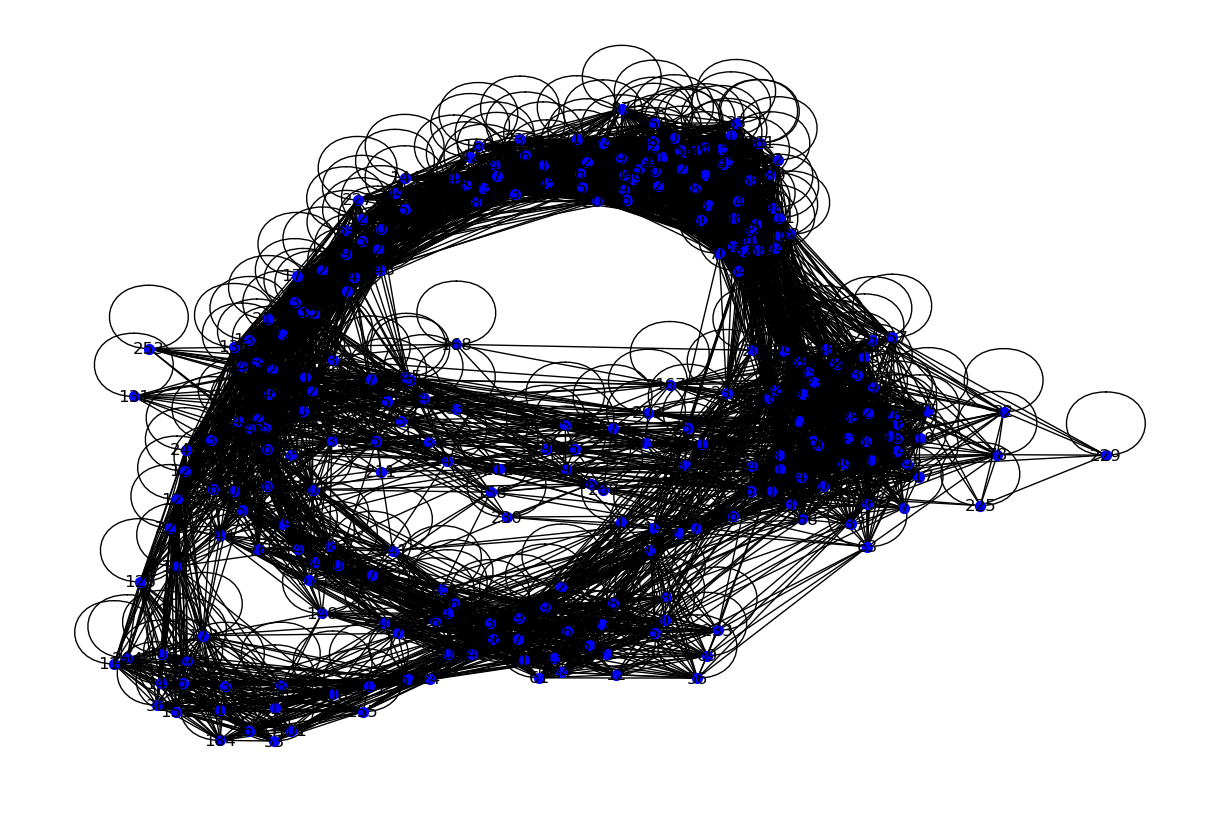

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a NetworkX graph from the edge_index tensor
G = nx.Graph()
edge_index_np = edge_index.numpy()
for edge in edge_index_np.T:
    G.add_edge(edge[0], edge[1])

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, node_size=50, node_color="blue", with_labels=True)
plt.show()


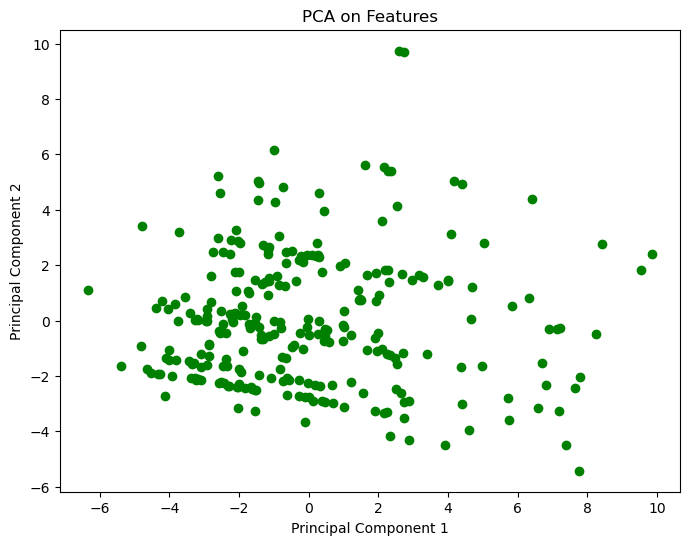

In [17]:
from sklearn.decomposition import PCA

# Using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='green')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Features')
plt.show()


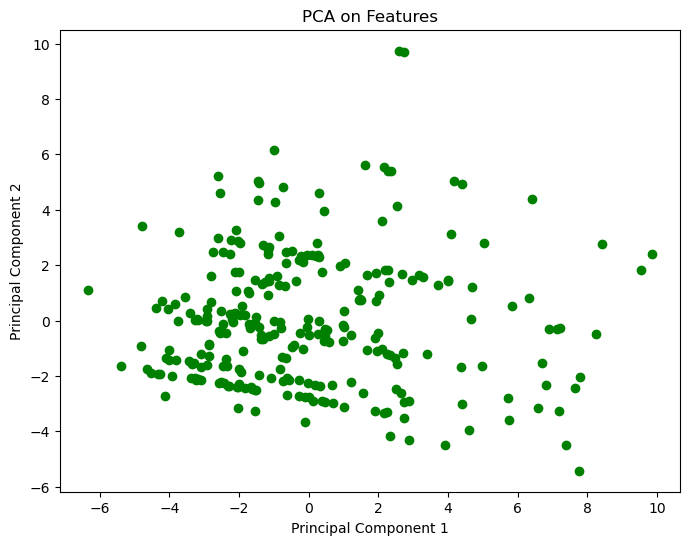

In [18]:
from sklearn.decomposition import PCA

# Using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='green')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Features')
plt.show()
